# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

In [328]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')

import yfinance as yf

## Portfolio 1

5 well-known tech stocks.

In [329]:
tickers = ['NVDA', 'META', 'GOOG', 'AAPL', 'AMZN']

start_date = dt.datetime.today()-dt.timedelta(days = 2*365)
end_date = dt.datetime.today()

stock = yf.download(tickers, start = start_date, end = end_date)

[*********************100%***********************]  5 of 5 completed


In [330]:
close = stock['Close']
normalized_returns = close/close.iloc[0]-1
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])
stock = pd.concat([stock, normalized_returns], axis =1 )


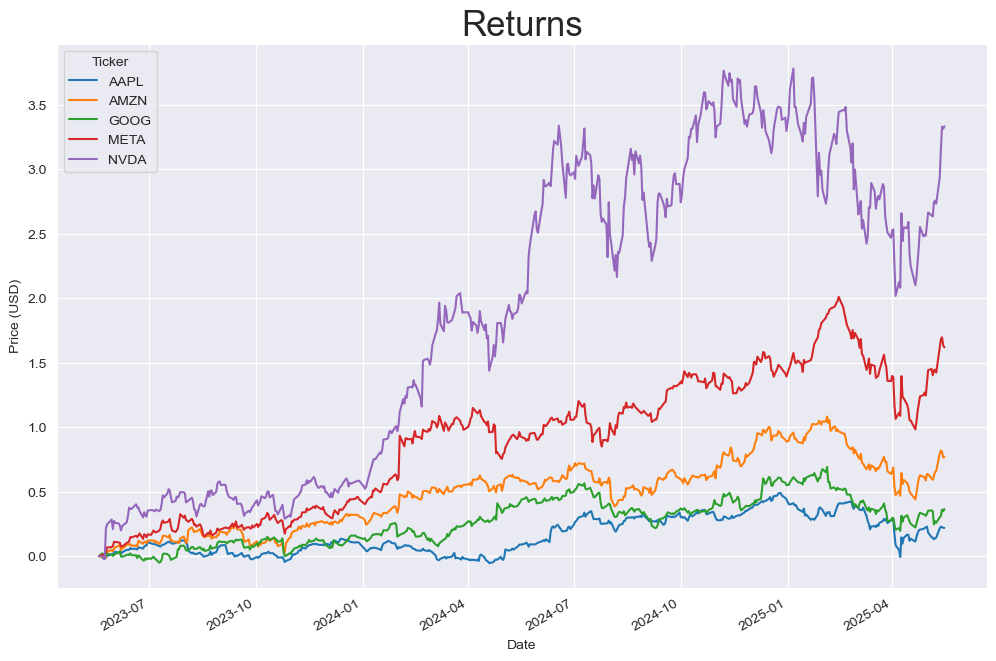

In [331]:
stock['Cumulative Return'].plot(figsize = (12,8))
plt.title(f'Returns', size = 25)
plt.ylabel('Price (USD)')
plt.show()

In [332]:
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()

mean_daily_returns = daily_returns.mean()
annualized_mean_returns = mean_daily_returns * 252
print(annualized_mean_returns)

annualized_volatility = {ticker: np.std(daily_returns[ticker])*np.sqrt(252) for ticker in tickers}
print(annualized_volatility)

Ticker
AAPL    0.099665
AMZN    0.287927
GOOG    0.157096
META    0.486241
NVDA    0.740554
dtype: float64
{'NVDA': np.float64(0.5429892199858574), 'META': np.float64(0.3605291375892268), 'GOOG': np.float64(0.29728050533955064), 'AAPL': np.float64(0.27150312002612365), 'AMZN': np.float64(0.31594604611395444)}


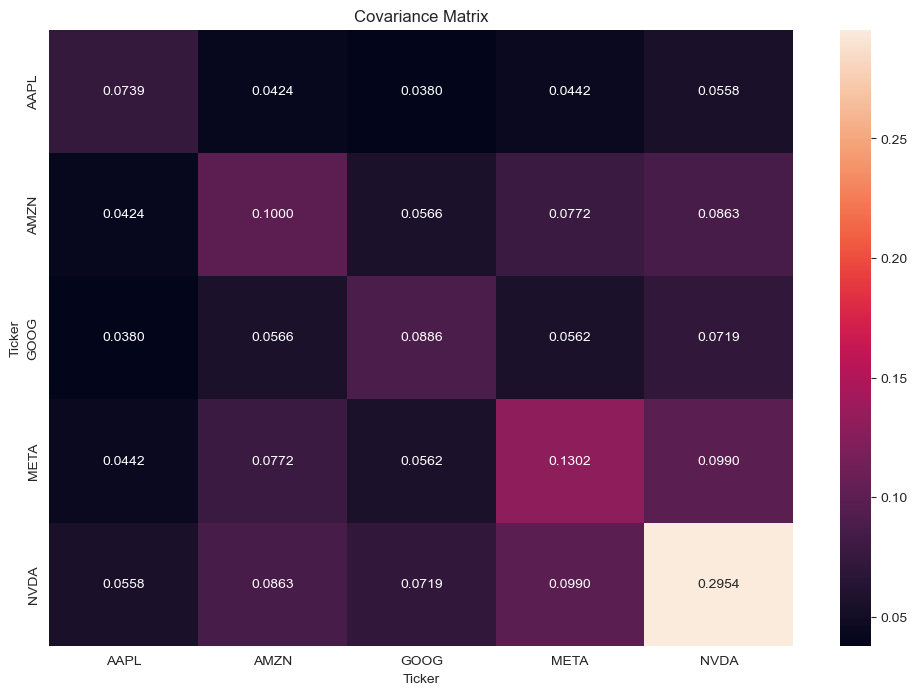

In [333]:
covariance_matrix = 252*((daily_returns).cov()) # annualized
plt.figure(figsize = (12,8))
sns.heatmap(covariance_matrix, annot=True, fmt ='.4f')
plt.title('Covariance Matrix')
plt.show()

In [334]:
n_assets = len(tickers)

# Initial guess for optimal weights
initial_weights = np.array([1/n_assets] * n_assets)

# Define weight constraints:
# 1. Sum of weights equals 1 
# 2. Allocate at least 5% of capital into each index in stock_symbols
# 3. Do not allocate more than 35% of capital into each index in stock_symbol
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-.05},
              {'type': 'ineq', 'fun': lambda weights: .35-max(weights)})

# Define the objective function to minimize portfolio variance
def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights))) # the covariance matrix was annualized above
    return portfolio_std_dev

# Run the optimization to find the optimal weights
result = minimize(portfolio_volatility, initial_weights, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

# Print the optimal weights and expected returns
print("Optimal Asset Weights to minimize volatility:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

print(f'The optimal volatility subject to the constraints is {result.fun}')

Optimal Asset Weights to minimize volatility:
NVDA: Weight = 0.3500
META: Weight = 0.1887
GOOG: Weight = 0.3499
AAPL: Weight = 0.0614
AMZN: Weight = 0.0500
The optimal volatility subject to the constraints is 0.2446852687002874


In [335]:
# Expected returns: dot product of weight vector with annualized mean returns of each stock
exp_return = np.dot(optimal_weights,annualized_mean_returns.values)
exp_return

np.float64(0.21106367838060952)

Let's find the interval $[\mu -\sigma,\mu+\sigma]$; this is annualized.

In [336]:
print('[',exp_return -result.fun,',',exp_return +result.fun,']')

[ -0.033621590319677874 , 0.4557489470808969 ]


We can also just look at the middle 68th quantile of the returns of the portfolio

In [337]:
weighted = daily_returns*optimal_weights
port_returns = weighted.sum(axis=1)
lower, upper = np.percentile(port_returns, [16, 84]) 

print('[',lower,',',upper,']')

[ -0.011584671541911468 , 0.013048391906243876 ]


Skewness: 0.2813907616914433
Excess Kurtosis: 8.776747313984904
Non-annualized Mean: 0.000837554279288133
Median: 0.0019008599837978292


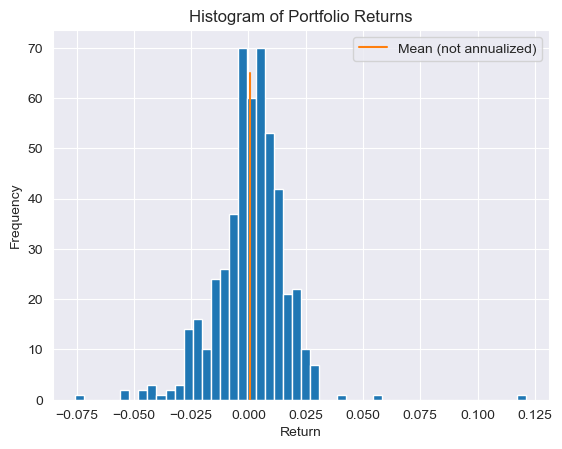

In [338]:
from scipy.stats import skew, kurtosis

skewness = skew(port_returns)
excess_kurtosis = kurtosis(port_returns)  # fisher=True by default so this returns excess kurtosis
med = np.median(port_returns)

print(f"Skewness: {skewness}")
print(f"Excess Kurtosis: {excess_kurtosis}")
print(f"Non-annualized Mean: {exp_return/252}")
print(f"Median: {med}")

plt.figure()
plt.hist(port_returns,bins=50)
plt.plot([exp_return/252,exp_return/252],[0,65], label = 'Mean (not annualized)')
plt.title("Histogram of Portfolio Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Portfolio 2

Having seen the plots of returns for the five tickers, we pick the two highest: NVIDIA and Meta.

In [339]:
# Plot the cumulative returns of the following stocks over the last two years

tickers = ['NVDA', 'META']

start_date = dt.datetime.today()-dt.timedelta(days = 2*365)
end_date = dt.datetime.today()

stock = yf.download(tickers, start = start_date, end = end_date)

[*********************100%***********************]  2 of 2 completed


In [340]:
close = stock['Close']
normalized_returns = close/close.iloc[0]-1
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])
stock = pd.concat([stock, normalized_returns], axis =1 )

In [341]:
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()

mean_daily_returns = daily_returns.mean()
annualized_mean_returns = mean_daily_returns * 252
print(annualized_mean_returns)

annualized_volatility = {ticker: np.std(daily_returns[ticker])*np.sqrt(252) for ticker in tickers}
print(annualized_volatility)

Ticker
META    0.486241
NVDA    0.740554
dtype: float64
{'NVDA': np.float64(0.5429891382570607), 'META': np.float64(0.3605292008923506)}


In [342]:
covariance_matrix = 252*((daily_returns).cov()) # annualized
covariance_matrix

Ticker,META,NVDA
Ticker,,
META,0.130242,0.098989
NVDA,0.098989,0.295429


In [343]:
n_assets = len(tickers)

# Initial guess for optimal weights
initial_weights = np.array([1/n_assets] * n_assets)

# Define weight constraints:
# 1. Sum of weights equals 1 
# 2. Allocate at least 5% of capital into each index in stock_symbols
# We no longer put a cap on the maximum amount we put into the portfolio
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-.05})

# Define the objective function to minimize portfolio variance
def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights))) # the covariance matrix was annualized above
    return portfolio_std_dev

# Run the optimization to find the optimal weights
result = minimize(portfolio_volatility, initial_weights, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

# Print the optimal weights and expected returns
print("Optimal Asset Weights to minimize volatility:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

print(f'The optimal volatility subject to the constraints is {result.fun}')

Optimal Asset Weights to minimize volatility:
NVDA: Weight = 0.8627
META: Weight = 0.1373
The optimal volatility subject to the constraints is 0.3548979665428313


In [344]:
# Expected returns: dot product of weight vector with annualized mean returns of each stock
exp_return = np.dot(optimal_weights,annualized_mean_returns.values)
exp_return

np.float64(0.5211463115695107)

Let's find the interval $[\mu -\sigma,\mu+\sigma]$; this is annualized.

In [345]:
print('[',exp_return -result.fun,',',exp_return +result.fun,']')

[ 0.16624834502667946 , 0.8760442781123421 ]


The middle 68th quantile

In [346]:
weighted = daily_returns*optimal_weights
port_returns = weighted.sum(axis=1)
lower, upper = np.percentile(port_returns, [16, 84]) 

print('[',lower,',',upper,']')

[ -0.015423529931173538 , 0.022169844773501184 ]


Skewness: 0.8239168960371278
Excess Kurtosis: 9.266601616379253
Non-annualized Mean: 0.00206804091892663
Median: 0.0020638775834663273


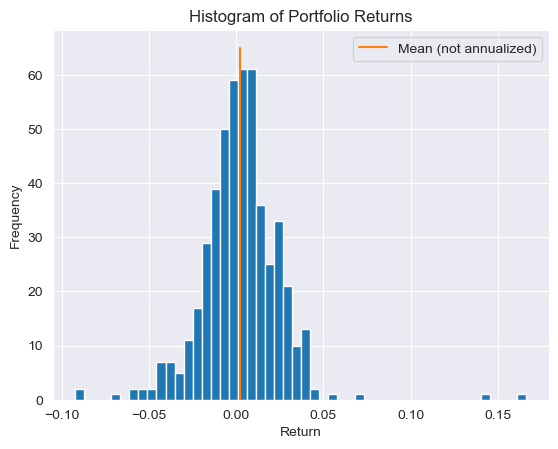

In [351]:
skewness = skew(port_returns)
excess_kurtosis = kurtosis(port_returns)  # fisher=True by default so this returns excess kurtosis
med = np.median(port_returns)

print(f"Skewness: {skewness}")
print(f"Excess Kurtosis: {excess_kurtosis}")
print(f"Non-annualized Mean: {exp_return/252}")
print(f"Median: {med}")

plt.figure()
plt.hist(port_returns,bins=50)
plt.plot([exp_return/252,exp_return/252],[0,65], label = 'Mean (not annualized)')
plt.title("Histogram of Portfolio Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend()
plt.show()


## Discussion

The first portfolio is more diversified by having 5 stocks and indeed, once we optimize the weights to minimize the volatility, that portfolio is less risky by that measure than the second portfolio which has only 2 stocks. However, when we look at the intervals $[\mu -\sigma,\mu+\sigma]$, the first portfolio dips into negative returns (only slightly) while the other is above. So despite being more volatile, the second portfolio has higher expected returns and one might deem it worth the risk.

Both portfolios exhibit positive skewness and excess kurtosis. So there fewer profitable days and we have "heavier" tails.

Of course, this is just based on the past 2 years of data (as of 18 May 2025) which may or may not be enough to properly judge.